In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.ensemble import RandomForestClassifier

## Data Overview

In [2]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

In [4]:
# Rows
print(df.shape[0])
# Columns
print(df.shape[1])

7043
21


In [5]:
# Missing values

print(df.isnull().sum().values.sum())

0


In [6]:
# Unique values

print(df.nunique())

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64


## Data Engineering

In [7]:
# Convert some object values to float type

df['MonthlyCharges'] = df['MonthlyCharges'].astype(float)
#df['TotalCharges'] = df['TotalCharges'].astype(float)

# There was an error when trying to convert total charges to float type, so we need to fix the spaces by replacing that with null values
df['TotalCharges'] = df["TotalCharges"].replace(" ",np.nan)

df['TotalCharges'] = df['TotalCharges'].astype(float)

In [8]:
print(df.TotalCharges.describe())
df.TotalCharges.isnull().sum()

count    7032.000000
mean     2283.300441
std      2266.771362
min        18.800000
25%       401.450000
50%      1397.475000
75%      3794.737500
max      8684.800000
Name: TotalCharges, dtype: float64


11

In [9]:
print(df.MonthlyCharges.describe())
df.MonthlyCharges.isnull().sum()

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64


0

In [10]:
# Replace null values in TotalCharges with tenure (in months) * monthlycharges

df.TotalCharges.fillna(value = df.tenure *  df.MonthlyCharges, inplace = True)

In [11]:
# Convert some int values to categorical type

df['SeniorCitizen'] = df.SeniorCitizen.astype('object')

## Data Exploration

In [12]:
df.describe().round()

,tenure,MonthlyCharges,TotalCharges
count,7043.0,7043.0,7043.0
mean,32.0,65.0,2280.0
std,25.0,30.0,2267.0
min,0.0,18.0,0.0
25%,9.0,36.0,399.0
50%,29.0,70.0,1395.0
75%,55.0,90.0,3787.0
max,72.0,119.0,8685.0


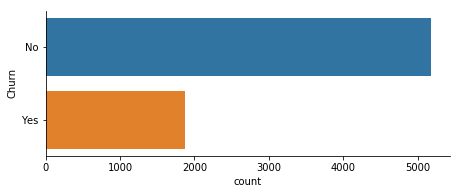

In [13]:
# Let's start by looking at the target variable
ax = sns.catplot(y="Churn", kind="count", data=df, height=2.6, aspect=2.5, orient='h')

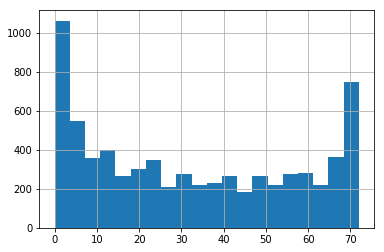

In [14]:
df['tenure'].hist(bins = 20)

We can see that 50% of customers stay with Telecom for at least 29 months. The average monthly charge is 65. The average total charge of a customer is 2,280.

/usr/lib/python3/dist-packages/scipy/stats/stats.py:1857: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


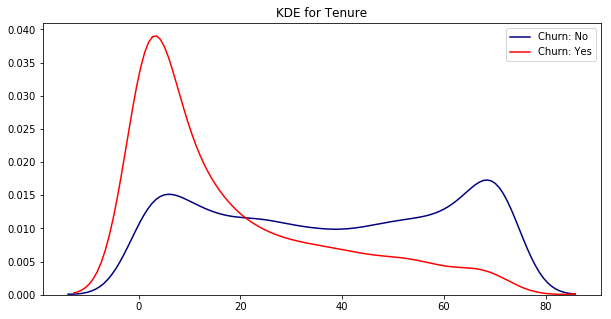

In [15]:
# Let's look at the Kernel Density Estimation between churn and the numerical variables to begin with:

plt.figure(figsize=(10, 5))
plt.title("KDE for {}".format('Tenure'))
ax0 = sns.kdeplot(df[df['Churn'] == 'No']['tenure'].dropna(), color= 'navy', label= 'Churn: No')
ax1 = sns.kdeplot(df[df['Churn'] == 'Yes']['tenure'].dropna(), color= 'red', label= 'Churn: Yes')

/usr/lib/python3/dist-packages/scipy/stats/stats.py:1857: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


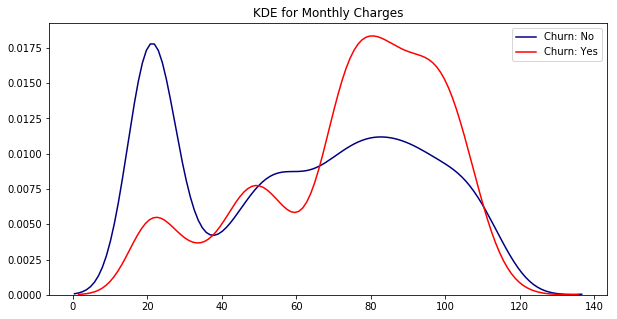

In [16]:
plt.figure(figsize=(10, 5))
plt.title("KDE for {}".format('Monthly Charges'))
ax0 = sns.kdeplot(df[df['Churn'] == 'No']['MonthlyCharges'].dropna(), color= 'navy', label= 'Churn: No')
ax1 = sns.kdeplot(df[df['Churn'] == 'Yes']['MonthlyCharges'].dropna(), color= 'red', label= 'Churn: Yes')

/usr/lib/python3/dist-packages/scipy/stats/stats.py:1857: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


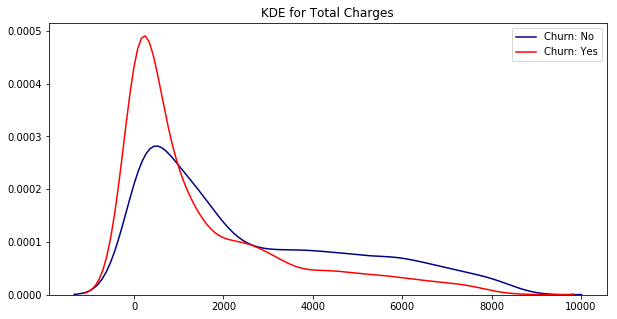

In [17]:
plt.figure(figsize=(10, 5))
plt.title("KDE for {}".format('Total Charges'))
ax0 = sns.kdeplot(df[df['Churn'] == 'No']['TotalCharges'].dropna(), color= 'navy', label= 'Churn: No')
ax1 = sns.kdeplot(df[df['Churn'] == 'Yes']['TotalCharges'].dropna(), color= 'red', label= 'Churn: Yes')

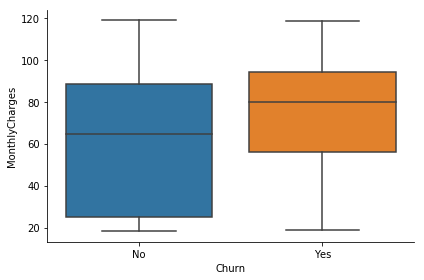

In [18]:
ax = sns.catplot(x="Churn", y="MonthlyCharges", kind="box",
                 data=df, height=4, aspect=1.5)

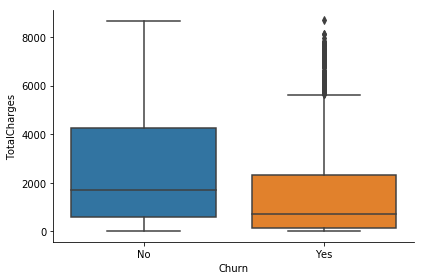

In [19]:
ax = sns.catplot(x="Churn", y="TotalCharges", kind="box",
                 data=df, height=4, aspect=1.5)

In [20]:
# Lets transform tenure into categorical data too

def tenure_cat(df) :
    
    if df["tenure"] <= 12 :
        return "Tenure_0-12"
    elif (df["tenure"] > 12) & (df["tenure"] <= 24 ):
        return "Tenure_12-24"
    elif (df["tenure"] > 24) & (df["tenure"] <= 48) :
        return "Tenure_24-48"
    elif (df["tenure"] > 48) & (df["tenure"] <= 60) :
        return "Tenure_48-60"
    elif df["tenure"] > 60 :
        return "Tenure_60+"

df["tenure_group"] = df.apply(lambda df:tenure_cat(df),axis = 1)

Text(0.5,1,'Average Total Spend by Tenure Group')

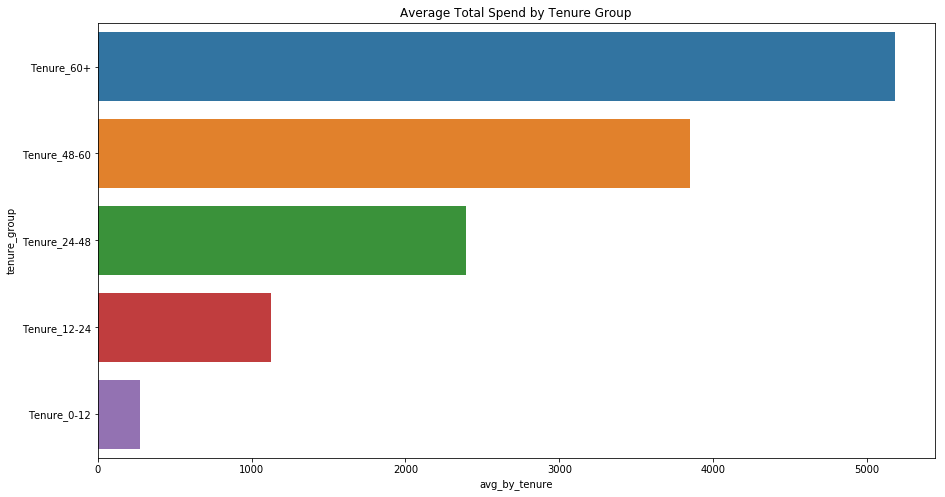

In [21]:
avg_by_tenure = df.groupby('tenure_group', as_index=False).agg({'TotalCharges':['count', 'sum']})

avg_by_tenure.columns = ['tenure_group', 'totalcharges_qty', 'totalcharges_sum']

avg_by_tenure['avg_by_tenure'] = avg_by_tenure['totalcharges_sum']/avg_by_tenure['totalcharges_qty']

avg_by_tenure = avg_by_tenure.sort_values(by='avg_by_tenure', ascending = False)

plt.figure(figsize=(15,8))
ax = sns.barplot(x="avg_by_tenure", y="tenure_group", data=avg_by_tenure)
ax.set_title('Average Total Spend by Tenure Group')

In [22]:
# Now let's look at the non-numerical variables

df.describe(include='object')

,customerID,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn,tenure_group
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,7043,2,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,2,5
top,8181-YHCMF,Male,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,No,Tenure_0-12
freq,1,3555,5901,3641,4933,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,5174,2186


In [23]:
# Let's see if a gender or age makes customer more likely to churn:

pd.crosstab(df.Churn, df.SeniorCitizen,
            margins = True)

SeniorCitizen,0,1,All
Churn,,,
No,4508,666,5174
Yes,1393,476,1869
All,5901,1142,7043


In [24]:
df.SeniorCitizen.value_counts(normalize = True)

0    0.837853
1    0.162147
Name: SeniorCitizen, dtype: float64

In [25]:
print('The percentage of senior citizen customers who leave the company: {}%'.format(476/1142*100))
print('The percentage of non-senior citizen customers who leave the company: {}%'.format(1393/5901*100))

The percentage of senior citizen customers who leave the company: 41.68126094570928%
The percentage of non-senior citizen customers who leave the company: 23.606168446026096%


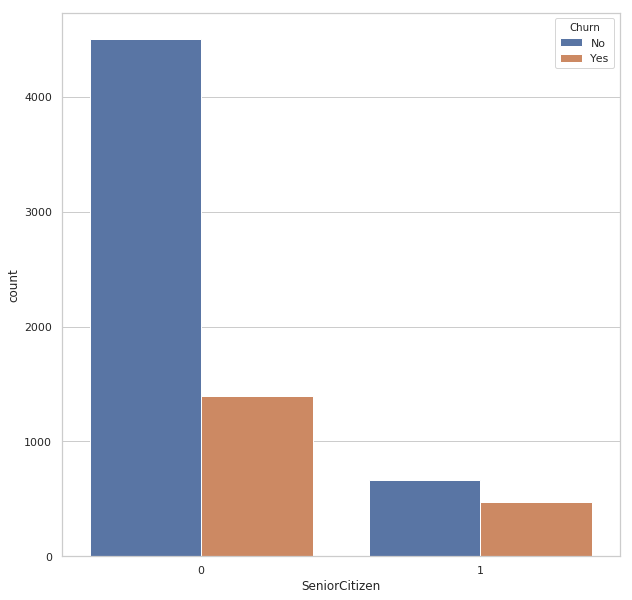

In [26]:
plt.figure(figsize = (10,10))
sns.set(style = 'whitegrid')

sns.countplot(df.SeniorCitizen, hue = df.Churn)

In [27]:
pd.crosstab(df.Churn, df.gender,
            margins = True)

gender,Female,Male,All
Churn,,,
No,2549,2625,5174
Yes,939,930,1869
All,3488,3555,7043


In [28]:
print('The percentage of male customers who leave the company: {}%'.format(930/3555*100))
print('The percentage of female customers who leave the company: {}%'.format(939/3488*100))

The percentage of male customers who leave the company: 26.160337552742618%
The percentage of female customers who leave the company: 26.920871559633024%


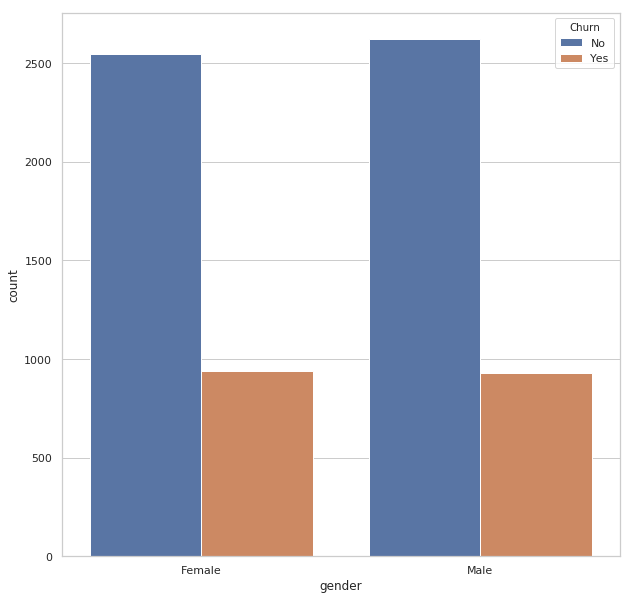

In [29]:
plt.figure(figsize = (10,10))
sns.set(style = 'whitegrid')

sns.countplot(df.gender, hue = df.Churn)

In [30]:
# Is there a relationship between contract type and churn?

pd.crosstab(df.Churn, df.Contract,
            margins = True)

Contract,Month-to-month,One year,Two year,All
Churn,,,,
No,2220,1307,1647,5174
Yes,1655,166,48,1869
All,3875,1473,1695,7043


In [31]:
print('The percentage of M2M customers who leave the company: {}%'.format(1655/3875*100))
print('The percentage of One-Year customers who leave the company: {}%'.format(166/1473*100))
print('The percentage of two-Year customers who leave the company: {}%'.format(48/1695*100))

The percentage of M2M customers who leave the company: 42.70967741935484%
The percentage of One-Year customers who leave the company: 11.269517990495586%
The percentage of two-Year customers who leave the company: 2.831858407079646%


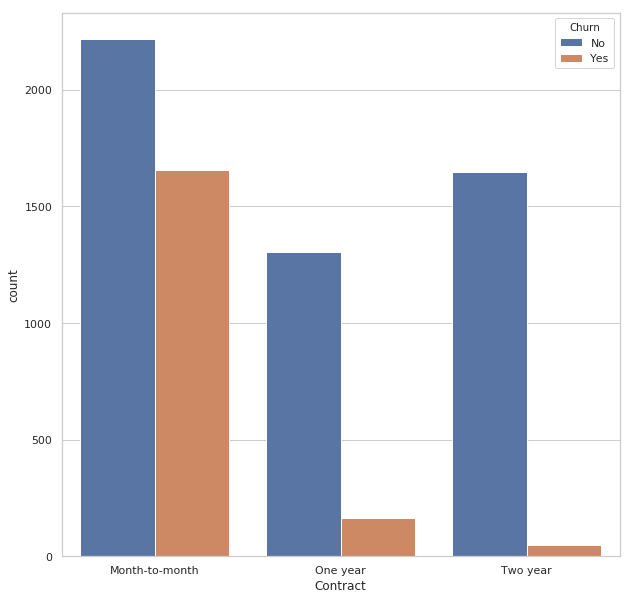

In [32]:
plt.figure(figsize = (10,10))
sns.set(style = 'whitegrid')

sns.countplot(df.Contract, hue = df.Churn)

In [33]:
pd.crosstab(df.Contract, df.SeniorCitizen,
            margins = True)

SeniorCitizen,0,1,All
Contract,,,
Month-to-month,3068,807,3875
One year,1283,190,1473
Two year,1550,145,1695
All,5901,1142,7043


In [34]:
print('The percentage of senior citizen customers who have M2M contract: {}%'.format(807/1142*100))
print('The percentage of non-senior citizen customers who have M2M contract: {}%'.format(3068/5901*100))

The percentage of senior citizen customers who have M2M contract: 70.66549912434326%
The percentage of non-senior citizen customers who have M2M contract: 51.99118793424843%


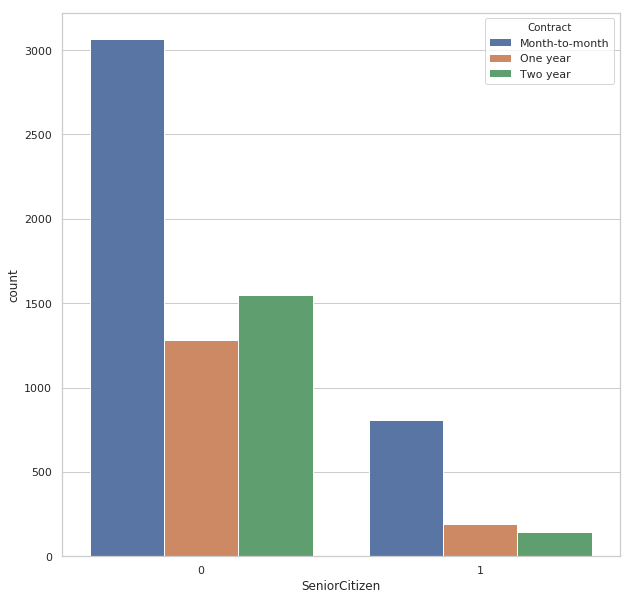

In [35]:
plt.figure(figsize = (10,10))
sns.set(style = 'whitegrid')

sns.countplot(df.SeniorCitizen, hue = df.Contract)

In [36]:
# Average spend for different contract types customers:
media_mes_idade = df.groupby('Contract').mean() 
media_mes_idade.round()

,tenure,MonthlyCharges,TotalCharges
Contract,,,
Month-to-month,18.0,66.0,1369.0
One year,42.0,65.0,3033.0
Two year,57.0,61.0,3707.0


In [37]:
# Average spend for Senior vs non-Senior customers:
media_mes_idade = df.groupby('SeniorCitizen').mean() 
media_mes_idade.round()

,tenure,MonthlyCharges,TotalCharges
SeniorCitizen,,,
0,32.0,62.0,2177.0
1,33.0,80.0,2810.0


Some takeaways: although senior citizens are only 16% of the customer base, they churn at a higher rate than non-senior citizen customers. 71% of senior citizens choose M-2-M contracts, which explains why their monthly charges are on average higher than the non-senior citizens (80 vs 62), as M2M contracts are typically more costly.

In [38]:
pd.crosstab(df.Churn, df.Partner,
            margins = True)

Partner,No,Yes,All
Churn,,,
No,2441,2733,5174
Yes,1200,669,1869
All,3641,3402,7043


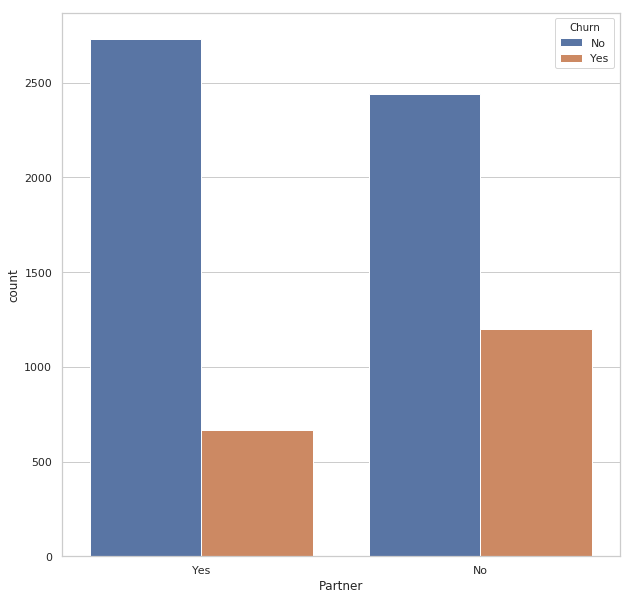

In [39]:
plt.figure(figsize = (10,10))
sns.set(style = 'whitegrid')

sns.countplot(df.Partner, hue = df.Churn)

## Correlation & Variable Importances

In [41]:
# Create dummies
df['Churn'] = 'Churn_' + df['Churn'].map(str)
churn_dummies = pd.get_dummies(df['Churn'])

df['SeniorCitizen'] = 'SeniorCitizen_' + df['SeniorCitizen'].map(str)
seniorcitizen_dummies = pd.get_dummies(df['SeniorCitizen'])

df['gender'] = 'gender_' + df['gender'].map(str)
gender_dummies = pd.get_dummies(df['gender'])

df['Contract'] = 'Contract_' + df['Contract'].map(str)
contract_dummies = pd.get_dummies(df['Contract'])

df['Partner'] = 'Partner_' + df['Partner'].map(str)
partner_dummies = pd.get_dummies(df['Partner'])


In [42]:
df = pd.concat([df, churn_dummies, seniorcitizen_dummies, gender_dummies, contract_dummies, partner_dummies], axis = 1)

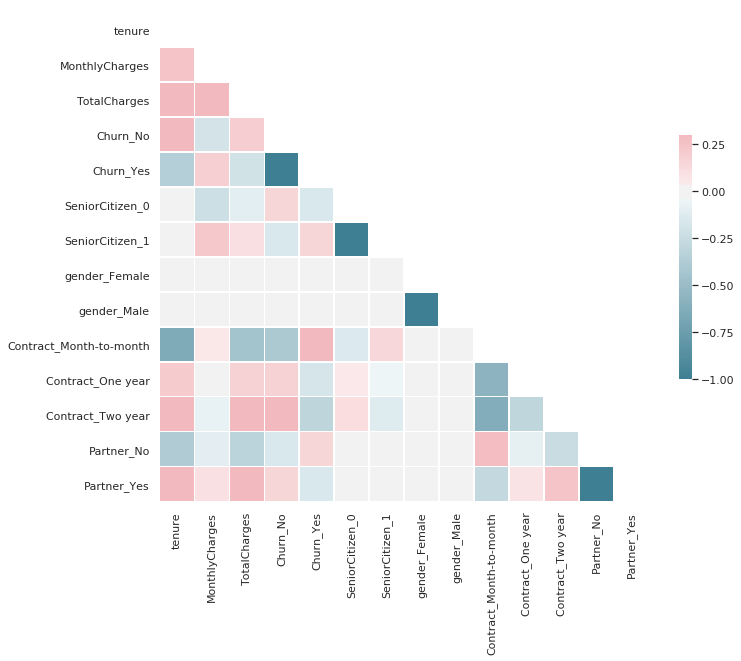

In [43]:
sns.set(style = 'white')

# Compute correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
params = {'random_state': 0, 'n_jobs': 4, 'n_estimators': 1000, 'max_depth': 8}
# One-hot encode
df = pd.get_dummies(df)
# Drop redundant columns (for features with two unique values)
drop = ['Churn_Yes', 'Churn_No', 'gender_Female', 'Partner_No',
        'Dependents_No']
x, y = df.drop(drop,axis=1), df['Churn_Yes']
# Fit RandomForest Classifier
clf = RandomForestClassifier(**params)
clf = clf.fit(x, y)
# Plot features importances
imp = pd.Series(data=clf.feature_importances_, index=x.columns).sort_values(ascending=False)
plt.figure(figsize=(10,12))
plt.title("Feature importance")
ax = sns.barplot(y=imp.index, x=imp.values, palette="Blues_d", orient='h')